In [474]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    SMOTE = None
    warnings.warn("imblearn not available. Install with `pip install imbalanced-learn` to enable SMOTE demos.")

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

#Load Excel Data

ctg_path = Path()  # Update if needed
assert ctg_path.exists(), f"Expected Excel file at {ctg_path}"

#Open the Sheets inside the Excel File 
#Load Sheet 2 with header from row 2
def read_feature_sheet(path: Path, sheet=1):
    xls = pd.ExcelFile(path)
    sheet_name = xls.sheet_names[sheet] if isinstance(sheet, int) else sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df

#Clean headers and data
def clean_ctg_sheet(df):

    # Drop empty columns and rows
    df = df.dropna(axis=1, how='all').dropna()

    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

#Load and clean
sheet2_raw = read_feature_sheet(ctg_path, sheet=1)
sheet2_cleaned = clean_ctg_sheet(sheet2_raw)

#Display summary and first 1000 rows

print("Shape:", sheet2_cleaned.shape)
print("Columns:", sheet2_cleaned.columns.tolist())
sheet2_cleaned.head(1000)
#Description of our information

sheet2_shape = sheet2_cleaned.shape
sheet2_info = sheet2_cleaned.info()
sheet2_cleaned.describe(include='all').T.head(300)



#Setting the Distribution for NSP

# Count and proportion of each class
class_counts = sheet2_cleaned['NSP'].value_counts().sort_index()
class_props = class_counts / class_counts.sum()

# Bar plot of class distribution
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(int), y=class_counts.values, ax=ax)
ax.set_xlabel('NSP Class')
ax.set_ylabel('Count')
ax.set_title('NSP Class Distribution')

# Annotate bars with count and proportion
for index, value in enumerate(class_counts.values):
    label = f"{value}\n{class_props.iloc[index]:.1%}"
    ax.text(index, value + 5, label, ha='center')

plt.tight_layout()
plt.show()

# Tabular summary
pd.DataFrame({
    'Class': class_counts.index.astype(int),
    'Count': class_counts.values,
    'Proportion': class_props.values
})

# Display groupings
for group, cols in feature_groups.items():
    print(f"\n🧠 {group} ({len(cols)} features):")
    for col in cols:
        print(f"• {col}")# Required import for Path
              

# Define column groups
physiological_signals = ['AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR']
variability_metrics = ['ASTV', 'mSTV', 'ALTV', 'mLTV']
histogram_descriptors = ['Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency']
timing_markers = ['b', 'e']
baseline_references = ['LB', 'LBE']
redundant_features = ['b', 'e','AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1','CLASS','A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
symbolic_features = ['A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS',]
target_variable = 'NSP'  # Use string, not list

# Organize into dictionary
feature_groups = {
    'Physiological Signals': physiological_signals,
    'Variability Metrics': variability_metrics,
    'Histogram Descriptors': histogram_descriptors,
    'Timing Markers': timing_markers,
    'Baseline References': baseline_references,
    'Redundant Features': redundant_features,
    'Symbolic Features': symbolic_features,
    'Target Variable': [target_variable]
}


# DATA CLEANING TO REMOVE NaNs in columns
sheet2_filled = sheet2_cleaned.dropna(axis=1)
print("Remaining NaNs:", sheet2_filled.isna().sum().sum())
sheet2_filled.head()

# Remove duplicate rows
duplicate_rows = sheet2_cleaned.duplicated().sum()
print("Duplicate rows:", duplicate_rows)
sheet2_cleaned = sheet2_cleaned.drop_duplicates()

# Drop label leakage and redundant columns
sheet2_cleaned = sheet2_cleaned.drop(columns=redundant_features, errors='ignore')

# Define numeric columns (excluding dropped ones)
numeric_cols = [col for col in sheet2_cleaned.columns if pd.api.types.is_numeric_dtype(sheet2_cleaned[col])]

# Prepare training data
X = sheet2_cleaned[numeric_cols]
y = sheet2_cleaned[target_variable]  # Use original sheet to retain target

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts().sort_index())

sheet2_cleaned.head()

NameError: name 'c' is not defined

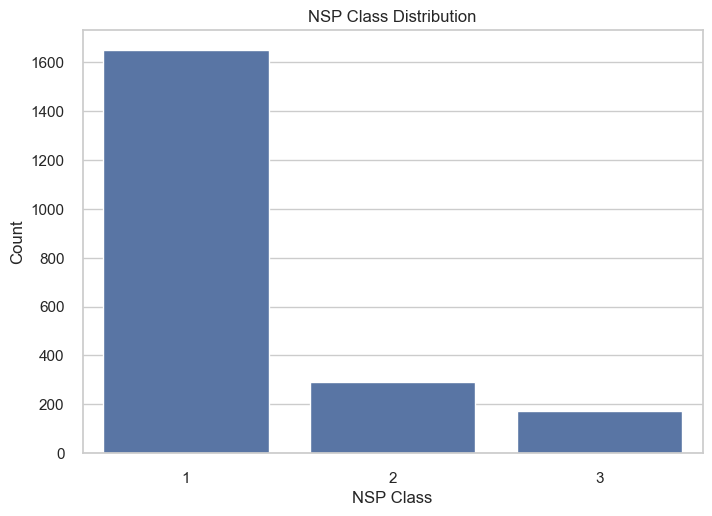

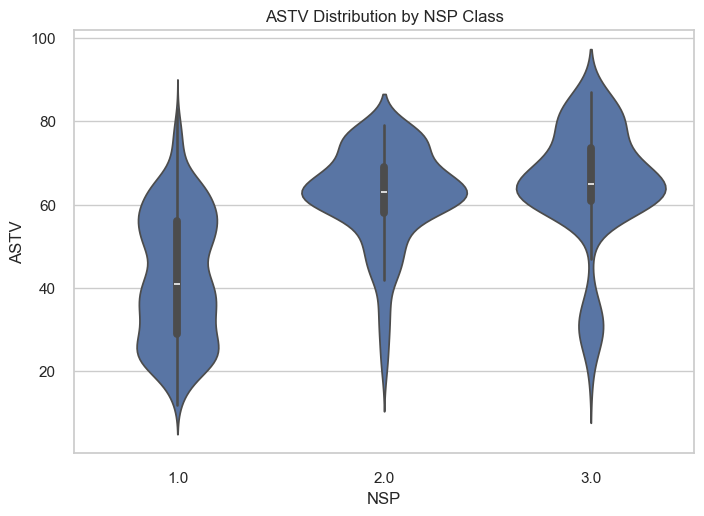

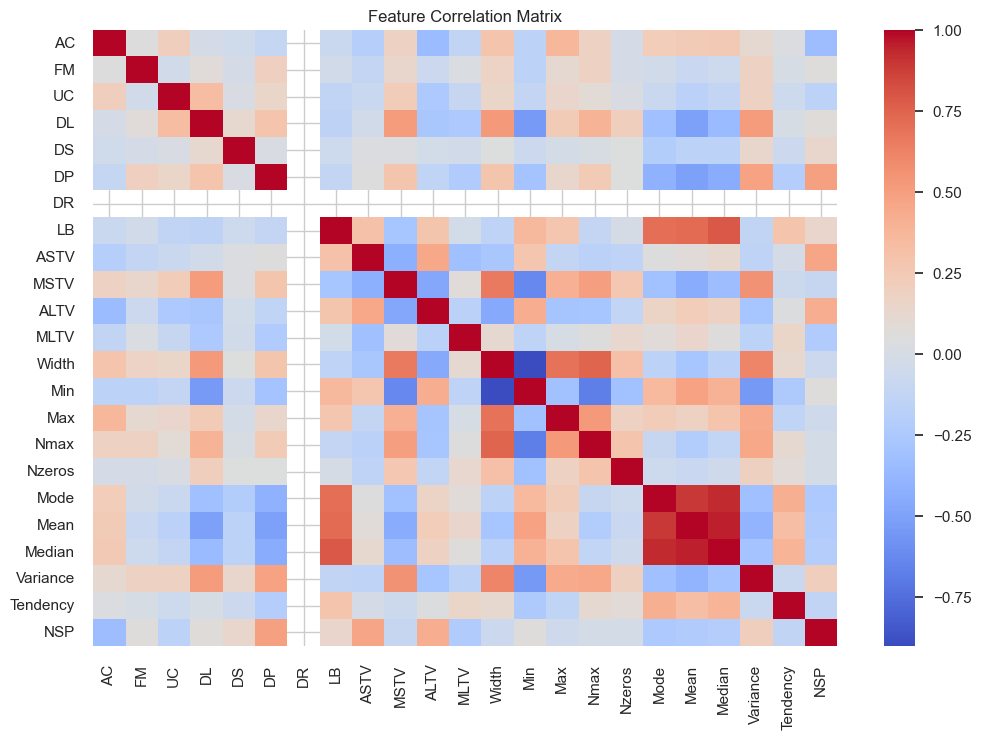

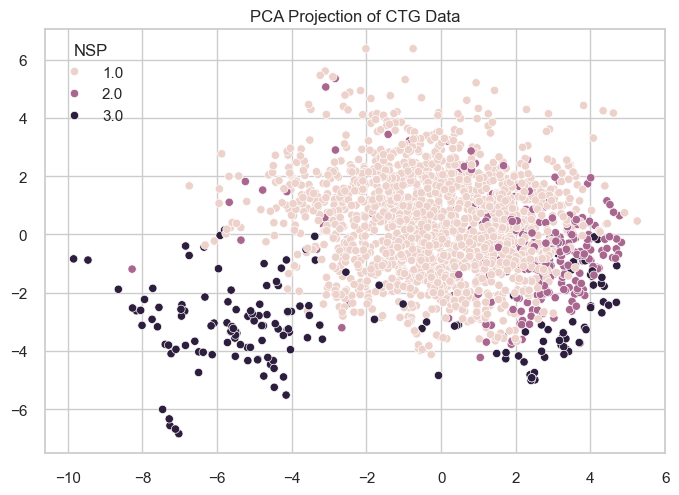

Top 10 features: ['AC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'Min', 'Variance', 'NSP']


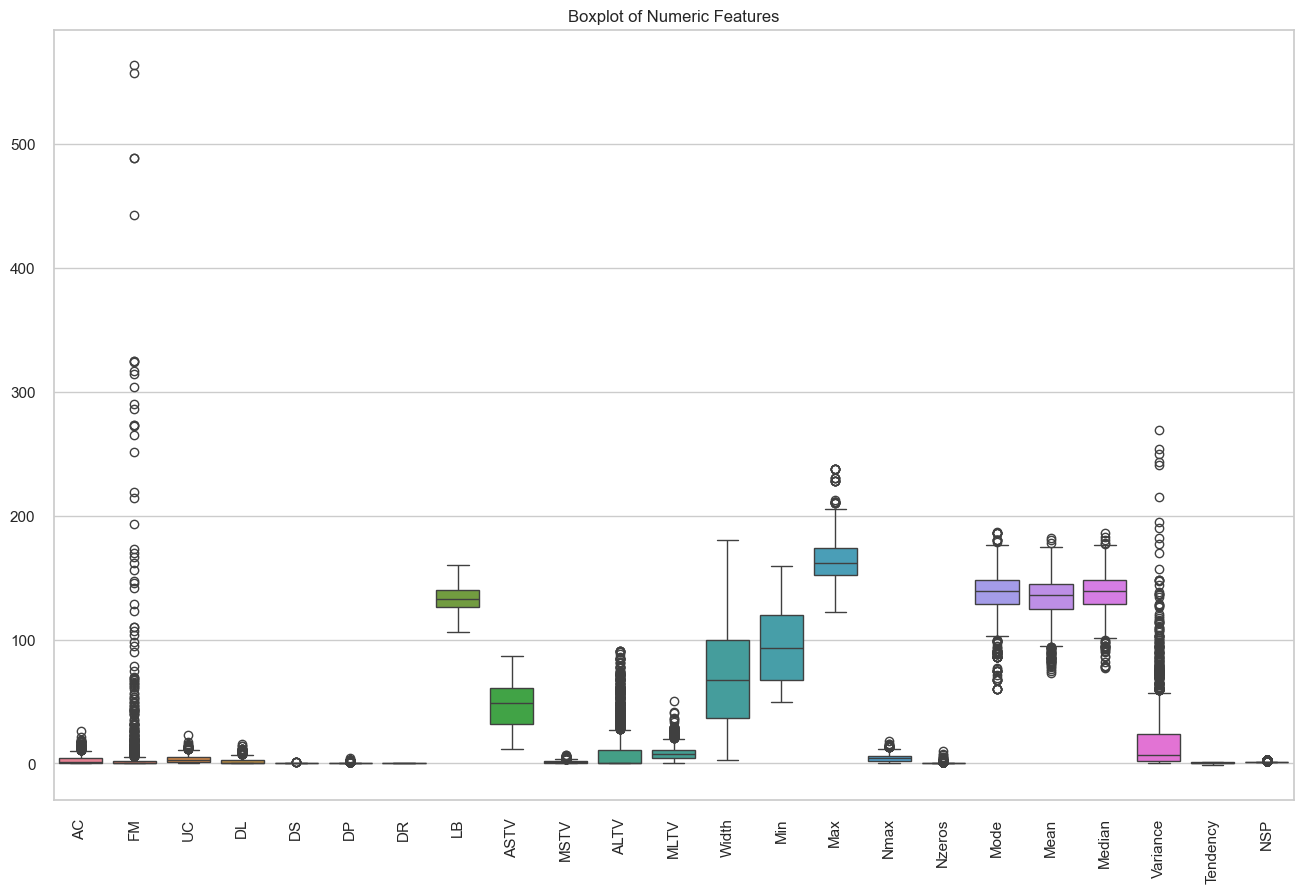

In [227]:
#NSP CLASS DISTRIBUTION
class_counts = sheet2_cleaned['NSP'].value_counts().sort_index()
class_props = class_counts / class_counts.sum()

sns.barplot(x=class_counts.index.astype(int), y=class_counts.values)
plt.title("NSP Class Distribution")
plt.xlabel("NSP Class")
plt.ylabel("Count")
plt.show()
#Feature Distribution By Class For ATV
sns.violinplot(x='NSP', y='ASTV', data=sheet2_cleaned)
plt.title("ASTV Distribution by NSP Class")
plt.show()
numeric_cols = [col for col in sheet2_cleaned.columns if pd.api.types.is_numeric_dtype(sheet2_cleaned[col])]
corr_matrix = sheet2_cleaned[numeric_cols].corr()
#Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()
#Dimennsionality Reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sheet2_cleaned[numeric_cols])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=sheet2_cleaned['NSP'])
plt.title("PCA Projection of CTG Data")
plt.show()

#MIN_MAX SCALER
X = sheet2_cleaned[numeric_cols]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = sheet2_cleaned['NSP']

selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X_scaled, y)

selected_features = [numeric_cols[i] for i in selector.get_support(indices=True)]
print("Top 10 features:", selected_features)

#Visual Inspection with BoxPlots 

plt.figure(figsize=(16, 10))
sns.boxplot(data=X)
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features")
plt.show()

#


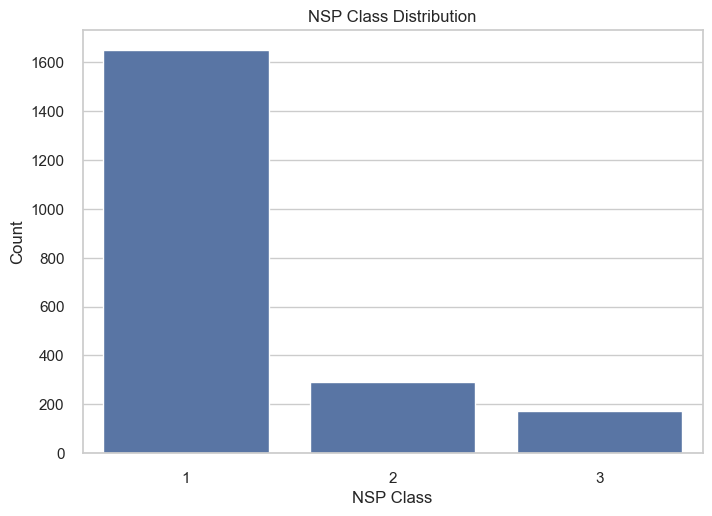

In [229]:
#NSP CLASS DISTRIBUTION
class_counts = sheet2_cleaned['NSP'].value_counts().sort_index()
class_props = class_counts / class_counts.sum()

sns.barplot(x=class_counts.index.astype(int), y=class_counts.values)
plt.title("NSP Class Distribution")
plt.xlabel("NSP Class")
plt.ylabel("Count")
plt.show()

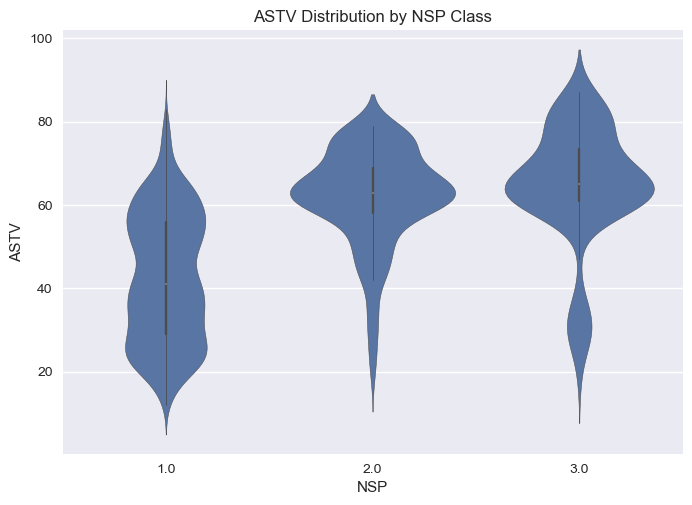

In [191]:
#Feature Distribution By Class For ATV
sns.violinplot(x='NSP', y='ASTV', data=sheet2_cleaned)
plt.title("ASTV Distribution by NSP Class")
plt.show()
numeric_cols = [col for col in sheet2_cleaned.columns if pd.api.types.is_numeric_dtype(sheet2_cleaned[col])]
corr_matrix = sheet2_cleaned[numeric_cols].corr()

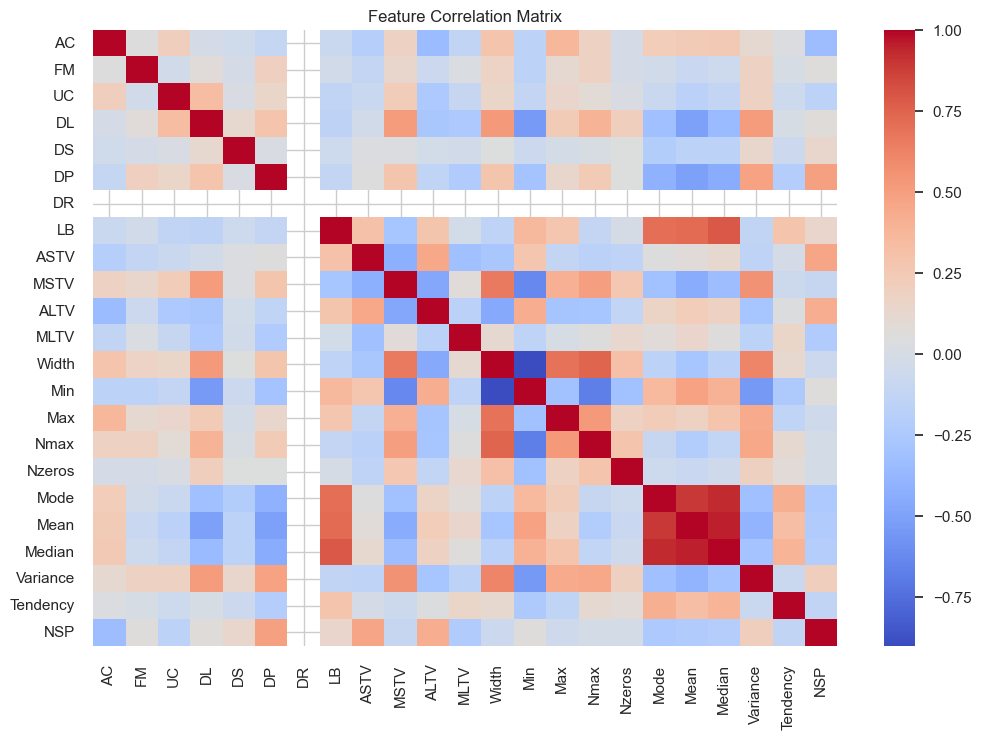

In [207]:
#Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

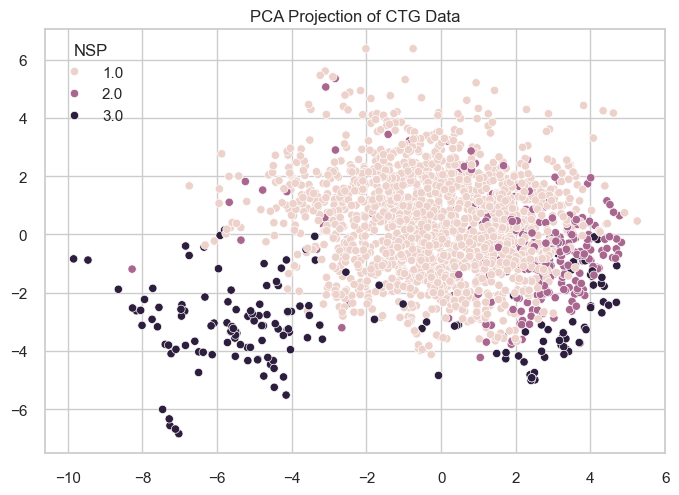

In [209]:
#Dimennsionality Reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sheet2_cleaned[numeric_cols])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=sheet2_cleaned['NSP'])
plt.title("PCA Projection of CTG Data")
plt.show()


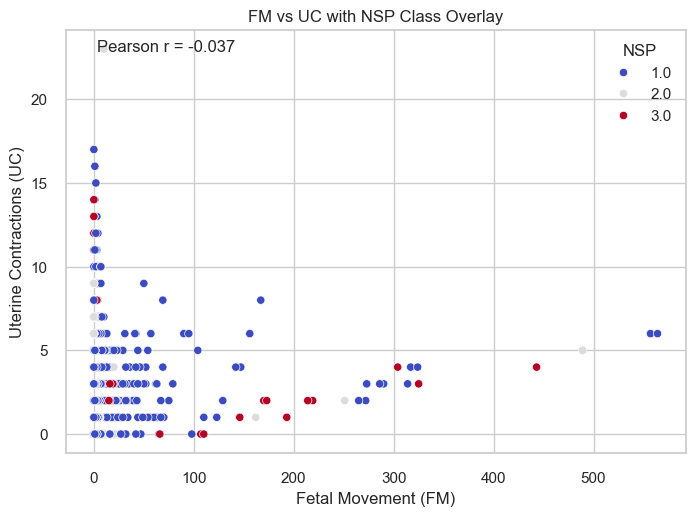

In [287]:

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Scatterplot
sns.scatterplot(data=sheet2_cleaned, x='FM', y='UC', hue='NSP', palette='coolwarm')
plt.title("FM vs UC with NSP Class Overlay")
plt.xlabel("Fetal Movement (FM)")
plt.ylabel("Uterine Contractions (UC)")

# Compute Pearson correlation
r_value, p_value = pearsonr(sheet2_cleaned['FM'], sheet2_cleaned['UC'])
plt.annotate(f"Pearson r = {r_value:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

plt.show()

In [291]:
#MIN_MAX SCALER
X = sheet2_cleaned[numeric_cols]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = sheet2_cleaned['NSP']

selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X_scaled, y)

selected_features = [numeric_cols[i] for i in selector.get_support(indices=True)]
print("Top 10 features:", selected_features)


Top 10 features: ['AC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'Min', 'Variance', 'NSP']


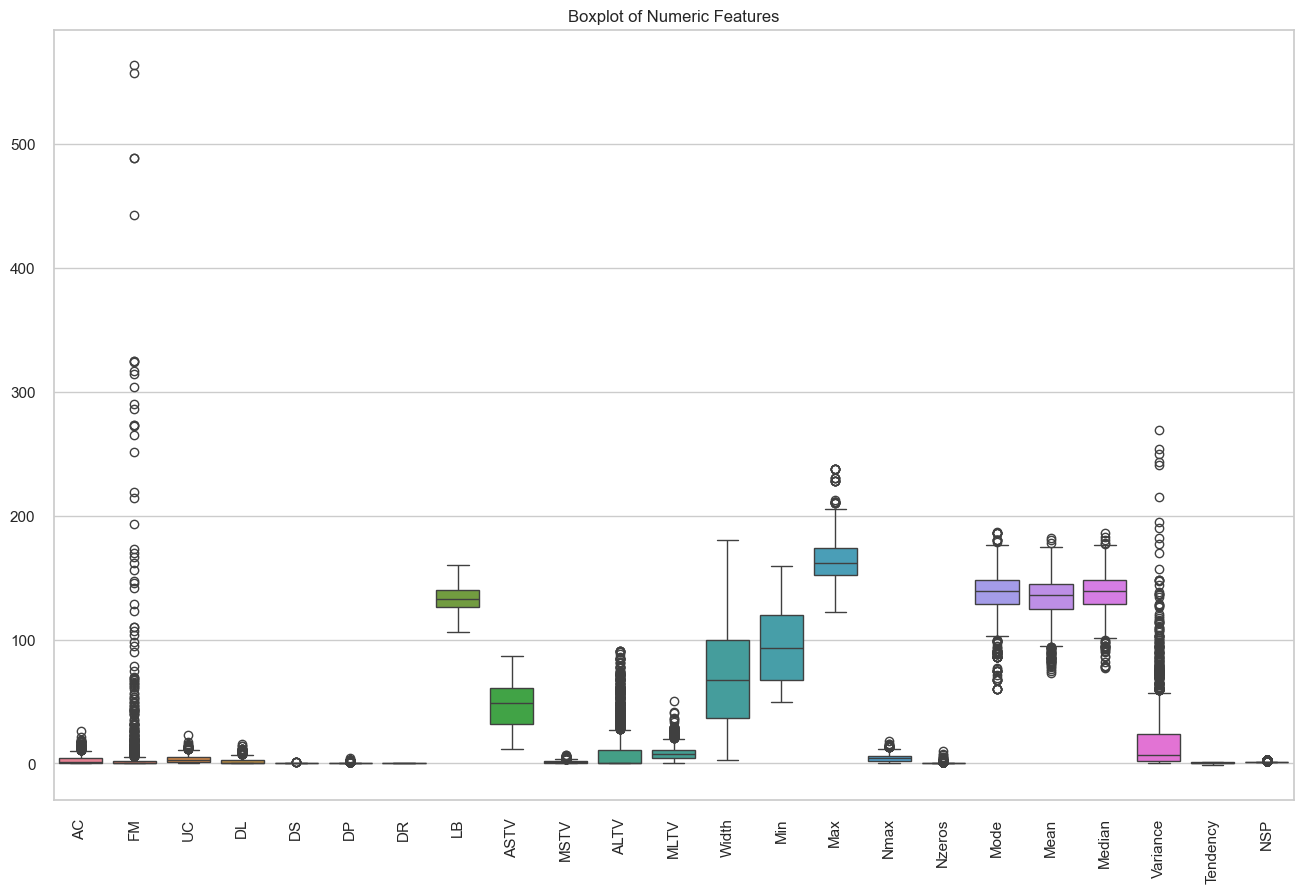

In [213]:
#Visual Inspection with BoxPlots 

plt.figure(figsize=(16, 10))
sns.boxplot(data=X)
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features")
plt.show()



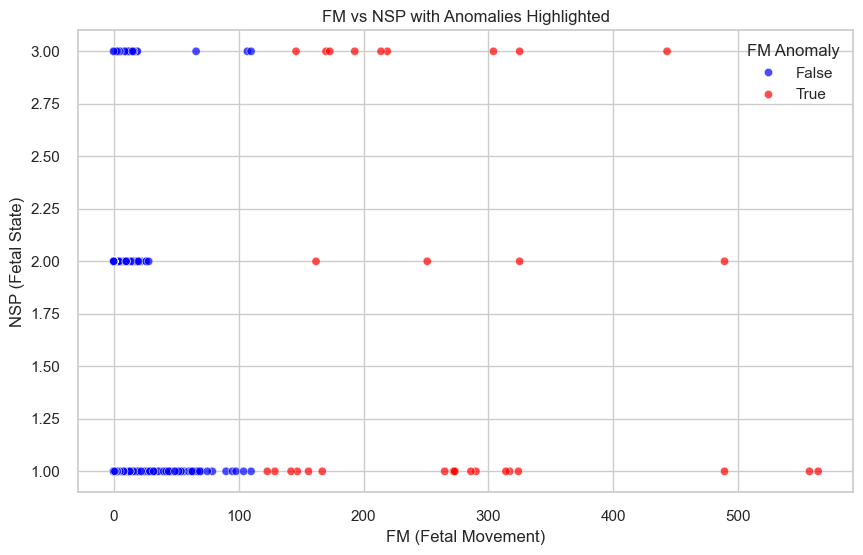

In [217]:
# Compute z-scores for FM
sheet2_cleaned['FM_zscore'] = zscore(sheet2_cleaned['FM'])

# Flag anomalies: z-score > 3 or < -3
sheet2_cleaned['FM_anomaly'] = sheet2_cleaned['FM_zscore'].abs() > 3

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sheet2_cleaned,
    x='FM',
    y='NSP',
    hue='FM_anomaly',
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)

plt.title('FM vs NSP with Anomalies Highlighted')
plt.xlabel('FM (Fetal Movement)')
plt.ylabel('NSP (Fetal State)')
plt.legend(title='FM Anomaly')

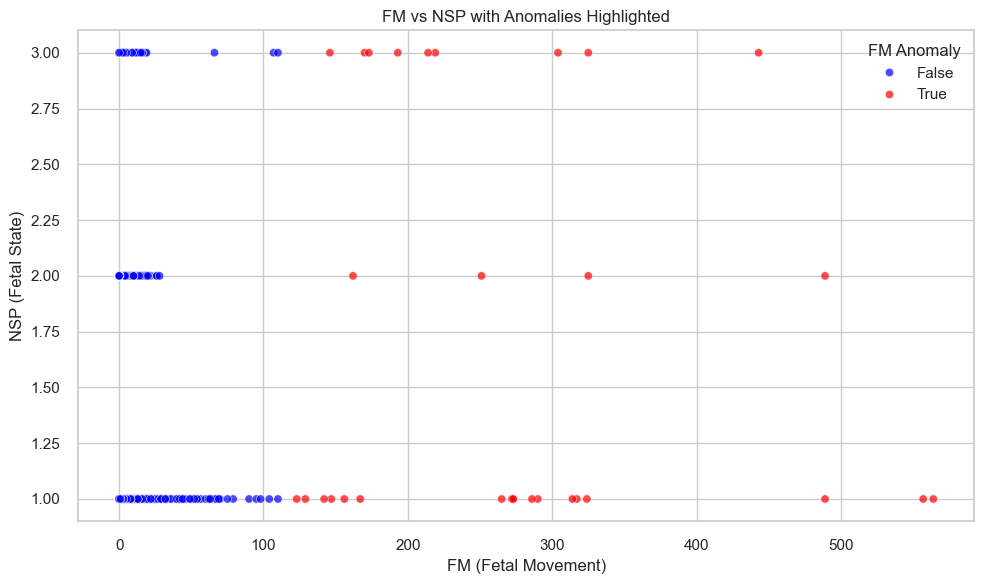

In [219]:

# Compute z-scores for FM
sheet2_cleaned['FM_zscore'] = zscore(sheet2_cleaned['FM'])

# Flag anomalies: z-score > 3 or < -3
sheet2_cleaned['FM_anomaly'] = sheet2_cleaned['FM_zscore'].abs() > 3

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sheet2_cleaned,
    x='FM',
    y='NSP',
    hue='FM_anomaly',
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)

plt.title('FM vs NSP with Anomalies Highlighted')
plt.xlabel('FM (Fetal Movement)')
plt.ylabel('NSP (Fetal State)')
plt.legend(title='FM Anomaly')
plt.tight_layout()
plt.show()



In [215]:
from scipy.stats import zscore

z_scores = np.abs(zscore(X))
anomaly_mask = (z_scores > 3)
anomaly_counts = anomaly_mask.sum(axis=0)

pd.DataFrame({
    'Feature': X.columns,
    'Anomalies': anomaly_counts
}).sort_values(by='Anomalies', ascending=False)

,Feature,Anomalies
DP,DP,69
ALTV,ALTV,59
Variance,Variance,44
Mode,Mode,39
AC,AC,35
MSTV,MSTV,33
MLTV,MLTV,33
FM,FM,31
Nzeros,Nzeros,28
DL,DL,28


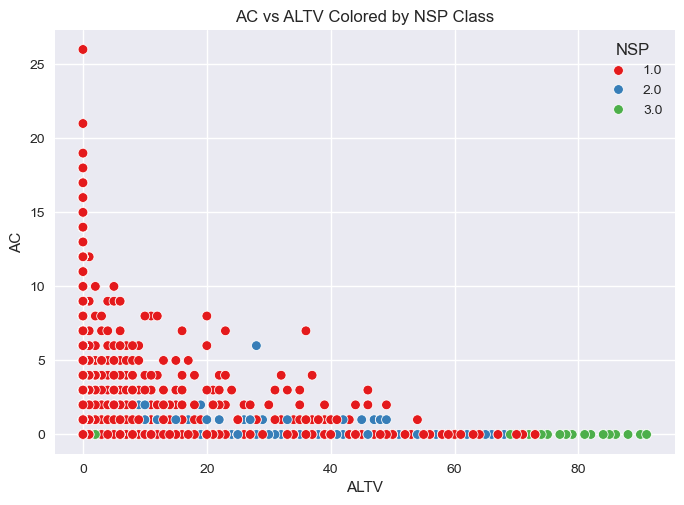

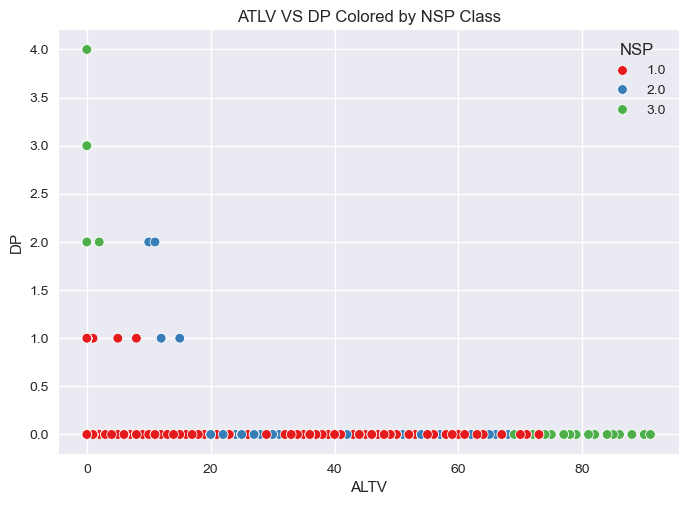

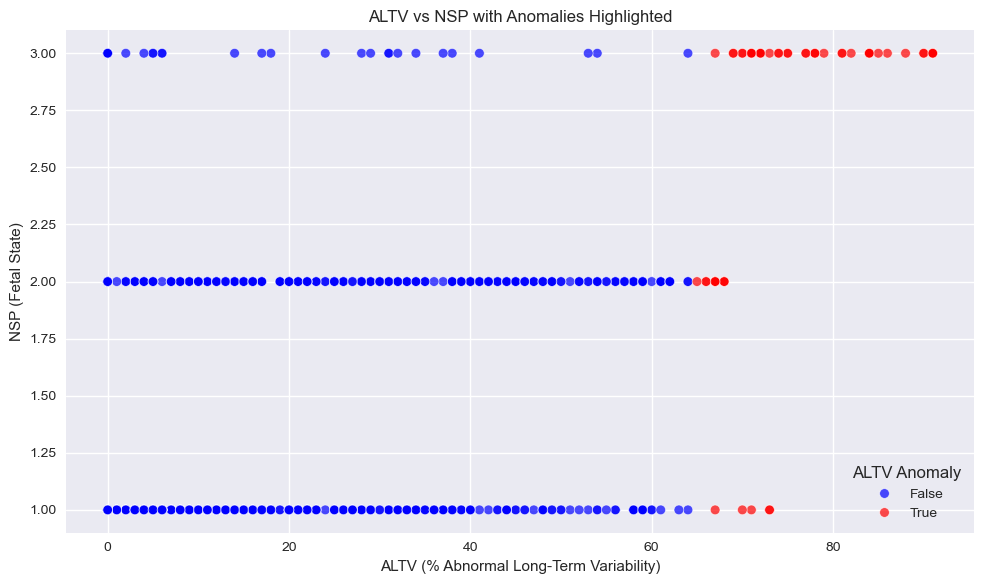

In [181]:
from scipy.stats import zscore

z_scores = np.abs(zscore(X))
anomaly_mask = (z_scores > 3)
anomaly_counts = anomaly_mask.sum(axis=0)

pd.DataFrame({
    'Feature': X.columns,
    'Anomalies': anomaly_counts
}).sort_values(by='Anomalies', ascending=False)


#AC VS ALTV
sns.scatterplot(data=sheet2_cleaned, x='ALTV', y='AC', hue='NSP', palette='Set1')
plt.title('AC vs ALTV Colored by NSP Class')
plt.xlabel('ALTV')
plt.ylabel('AC')
plt.show()

#AC VS DP
sns.scatterplot(data=sheet2_cleaned, x='ALTV', y='DP', hue='NSP', palette='Set1')
plt.title('ATLV VS DP Colored by NSP Class')
plt.xlabel('ALTV')
plt.ylabel('DP')
plt.show()

# Compute z-scores for ALTV
sheet2_cleaned['ALTV_z'] = zscore(sheet2_cleaned['ALTV'])
# Flag anomalies: z-score > 3
sheet2_cleaned['ALTV_anomaly'] = sheet2_cleaned['ALTV_z'].abs() > 3
# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sheet2_cleaned,
    x='ALTV',
    y='NSP',
    hue='ALTV_anomaly',
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('ALTV vs NSP with Anomalies Highlighted')
plt.xlabel('ALTV (% Abnormal Long-Term Variability)')
plt.ylabel('NSP (Fetal State)')
plt.legend(title='ALTV Anomaly')
plt.tight_layout()
plt.show()

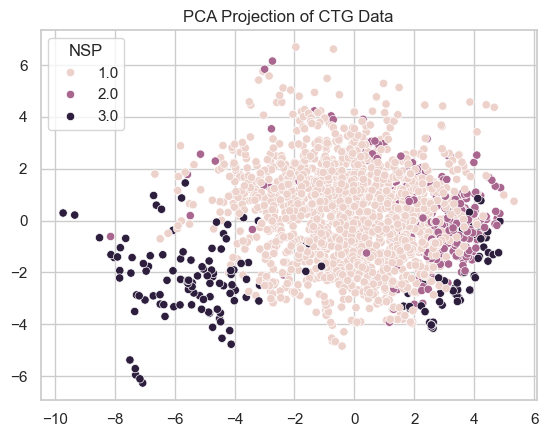

In [115]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA Projection of CTG Data")
plt.show()

# Your PCA scatter plot shows:
#Class 1 (Normal) forms a dense cluster
#Classes 2 and 3 are more dispersed
#Some points lie far from all clusters → potential anomalies

In [319]:
# 1. Inspect the target column
sheet2_cleaned[target_variable].value_counts(dropna=False)
sheet2_cleaned[target_variable].unique()

# 2. Drop or impute missing labels
y = sheet2_cleaned[target_variable]

# Option A – drop rows with missing NSP values
mask = y.notna()
y = y.loc[mask]

# Optionally keep the aligned feature matrix if needed later
# X = clean_df.loc[mask, feature_cols]

# 3. Make sure the dtype is consistent (integers)
y = y.astype(int)

# 4. Recompute classes and weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes,
                               y=y)

class_weight_dict = dict(zip(classes, weights))
class_weight_dict

# Ensures that rare classes (e.g., NSP = 3) are not ignored by the model
# Helps classifiers like Logistic Regression, Random Forest, or XGBoost treat all classes fairly
# Prevents bias toward majority class (NSP = 1)

{1: 0.4279935275080906, 2: 2.4072810011376564, 3: 4.0304761904761905}

In [337]:
def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    fit_kwargs = fit_kwargs or {}
    estimator.fit(X_train, y_train, **fit_kwargs)
    y_pred = estimator.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1})
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}")
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()
    return estimator, y_pred

classes

array([1, 2, 3])

Custom Threshold — NSP = 3 if prob > 0.3


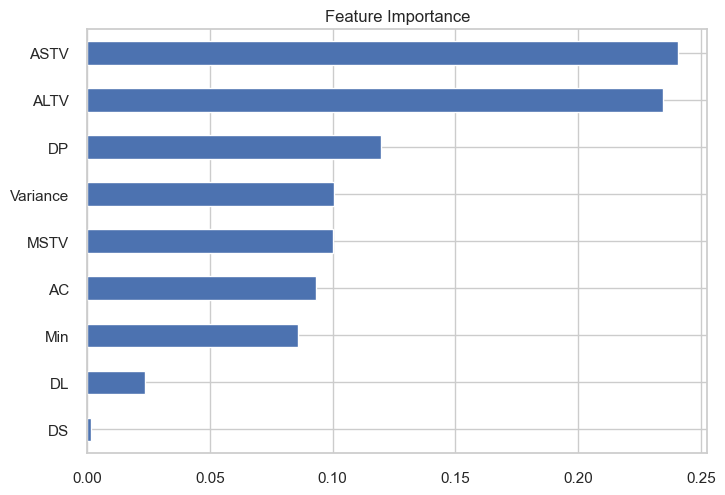

In [410]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier







target_variable = 'NSP'
y = sheet2_cleaned[target_variable]
mask = y.notna()
y = y.loc[mask].astype(int)

## Step 2: Compute Class Weights for Imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, weights))

# Step 3: Select Features Based on Visual Insights
selected_features = ['AC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'Min', 'Variance']
X = sheet2_cleaned[selected_features]

#Step 4 : Add Ethical Alert Logic
def ethical_alert(row):
    if row['DP'] > 0 and row['ALTV'] > 80:
        return 'Review: Possible distress'
    elif row['AC'] < 5 and row['ASTV'] < 10:
        return 'Review: Low reactivity'
    else:
        return 'No alert'

sheet2_cleaned['Ethical_Alert'] = sheet2_cleaned.apply(ethical_alert, axis=1)

# Step 5: Train/Test Split
from sklearn.model_selection import train_test_split

y = sheet2_cleaned['NSP'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

y_pred_custom = np.array([
    3 if p[2] > 0.3 else np.argmax(p) + 1
    for p in probs
])

print("Custom Threshold — NSP = 3 if prob > 0.3")


import pandas as pd

feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()







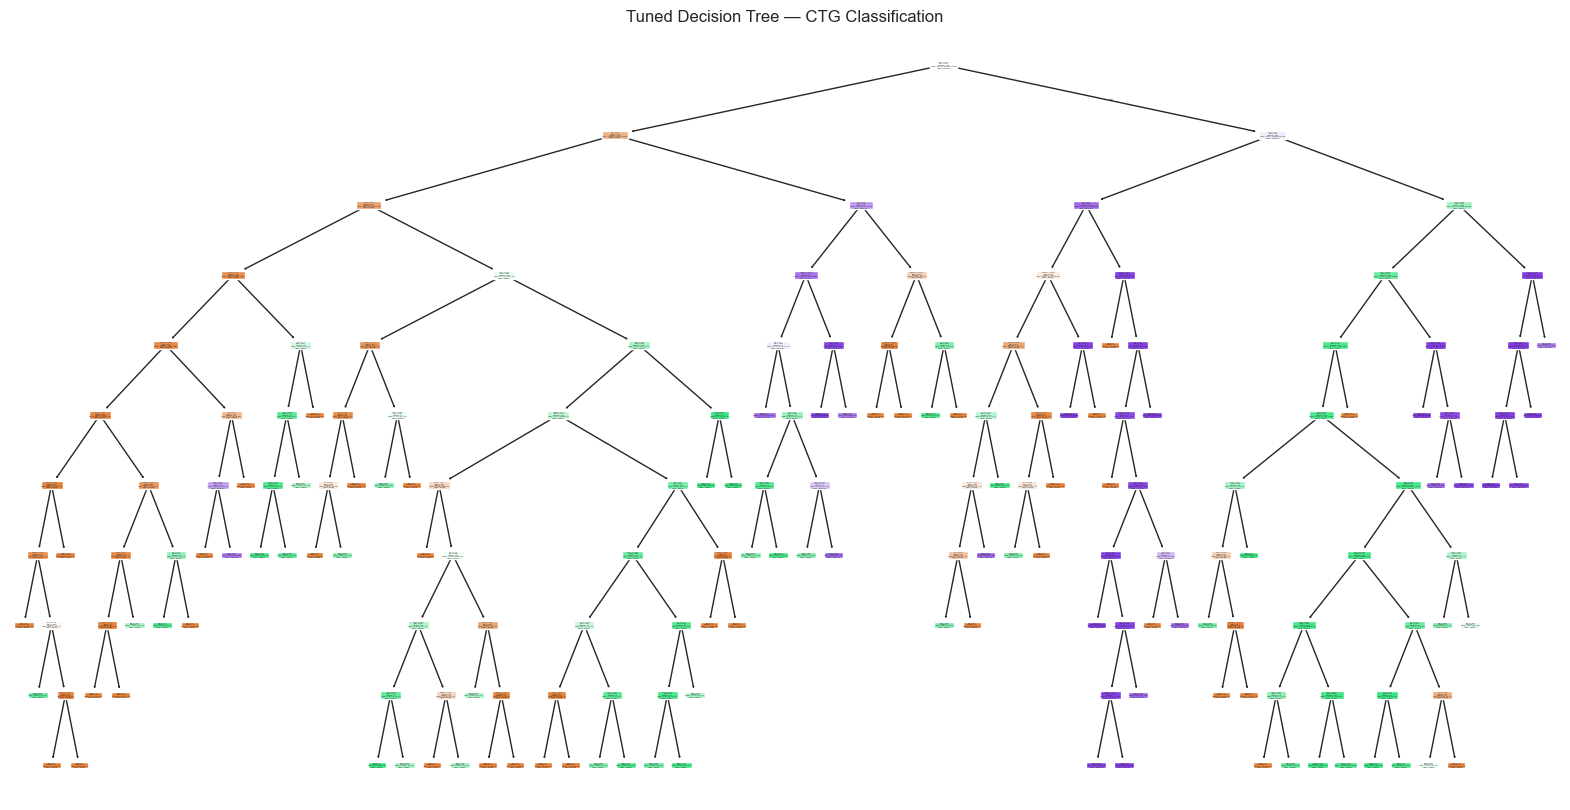

Gradient Boosting — Balanced Accuracy: 0.894, Macro F1: 0.872
              precision    recall  f1-score   support

           1      0.966     0.936     0.951       330
           2      0.731     0.831     0.778        59
           3      0.865     0.914     0.889        35

    accuracy                          0.920       424
   macro avg      0.854     0.894     0.872       424
weighted avg      0.925     0.920     0.922       424



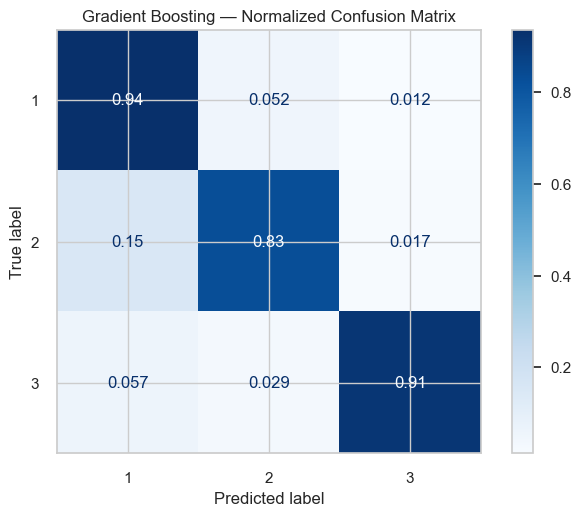

In [412]:
#Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': [class_weight_dict]
}

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=['Normal', 'Suspect', 'Pathologic'])
plt.title("Tuned Decision Tree — CTG Classification")
plt.show()

probs = best_tree.predict_proba(X_test)
y_pred_custom = np.array([
    3 if p[2] > 0.3 else np.argmax(p) + 1
    for p in probs
])

flagged = sheet2_cleaned.loc[
    (sheet2_cleaned['NSP'] == 1) & 
    (sheet2_cleaned['Ethical_Alert'] != 'No alert')
]
_ = evaluate_model(
    'Gradient Boosting',
    gb_pipeline,
    X_train, y_train,
    X_test, y_test,
    fit_kwargs=gb_fit_kwargs,
    display_report=True
)


Gradient Boosting — Balanced Accuracy: 0.894, Macro F1: 0.872
              precision    recall  f1-score   support

           1      0.966     0.936     0.951       330
           2      0.731     0.831     0.778        59
           3      0.865     0.914     0.889        35

    accuracy                          0.920       424
   macro avg      0.854     0.894     0.872       424
weighted avg      0.925     0.920     0.922       424



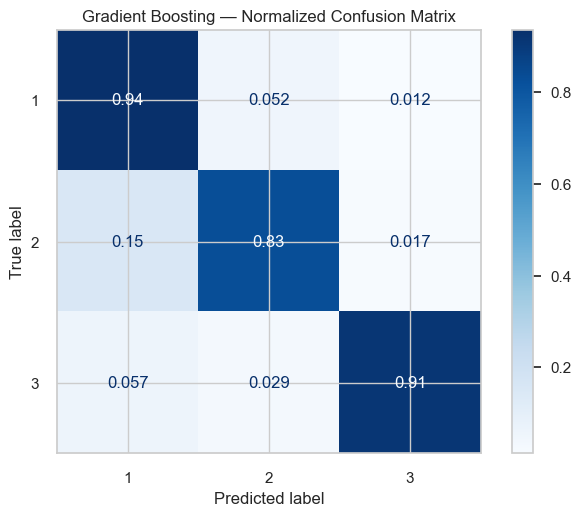

In [414]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=300,       # More trees for better learning
    learning_rate=0.05,     # Shrinks each tree’s contribution
    max_depth=3,            # Shallow trees reduce overfitting
    random_state=42
)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', gb_model)
])

sample_weight_train = y_train.map(class_weight_dict)

gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}

_ = evaluate_model(
    'Gradient Boosting',
    gb_pipeline,
    X_train, y_train,
    X_test, y_test,
    fit_kwargs=gb_fit_kwargs,
    display_report=True
)


Support Vector Machine — Balanced Accuracy: 0.881, Macro F1: 0.812
              precision    recall  f1-score   support

           1      0.976     0.852     0.909       330
           2      0.521     0.847     0.645        59
           3      0.825     0.943     0.880        35

    accuracy                          0.858       424
   macro avg      0.774     0.881     0.812       424
weighted avg      0.900     0.858     0.870       424



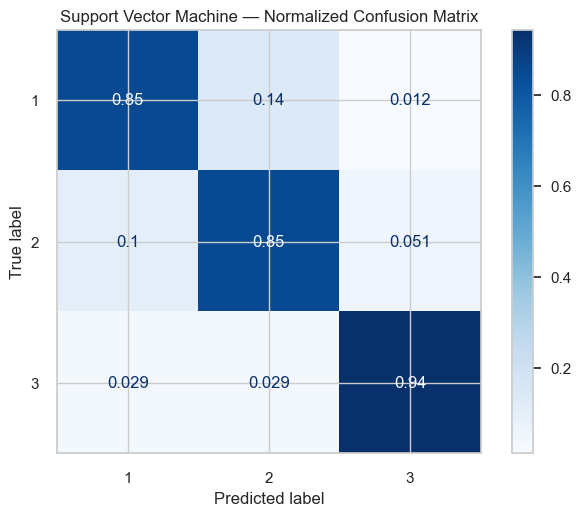

In [382]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=2.0,
        gamma='scale',
        class_weight='balanced',
        probability=True  # Enables predict_proba for threshold tuning
    ))
])
_ = evaluate_model(
    'Support Vector Machine',
    svm_pipeline,
    X_train, y_train,
    X_test, y_test,
    display_report=True
)

#Not good bceause it

k-Nearest Neighbors — Balanced Accuracy: 0.743, Macro F1: 0.778
              precision    recall  f1-score   support

           1      0.917     0.967     0.941       330
           2      0.723     0.576     0.642        59
           3      0.828     0.686     0.750        35

    accuracy                          0.889       424
   macro avg      0.823     0.743     0.778       424
weighted avg      0.882     0.889     0.884       424



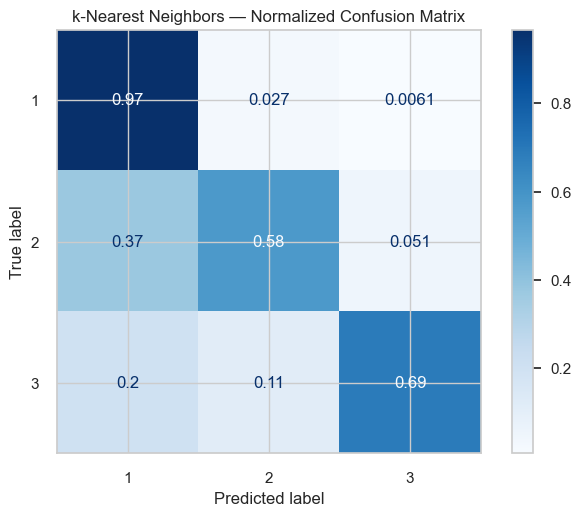

In [462]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15))
])

# Evaluate and capture metrics
knn_metrics = evaluate_model(
    'k-Nearest Neighbors',
    knn_pipeline,
    X_train, y_train,
    X_test, y_test,
    display_report=True,
     # Ensure your function returns a dict of metrics
)



Neural Network — Balanced Accuracy: 0.882, Macro F1: 0.875
              precision    recall  f1-score   support

           1      0.966     0.942     0.954       330
           2      0.714     0.847     0.775        59
           3      0.938     0.857     0.896        35

    accuracy                          0.922       424
   macro avg      0.873     0.882     0.875       424
weighted avg      0.928     0.922     0.924       424



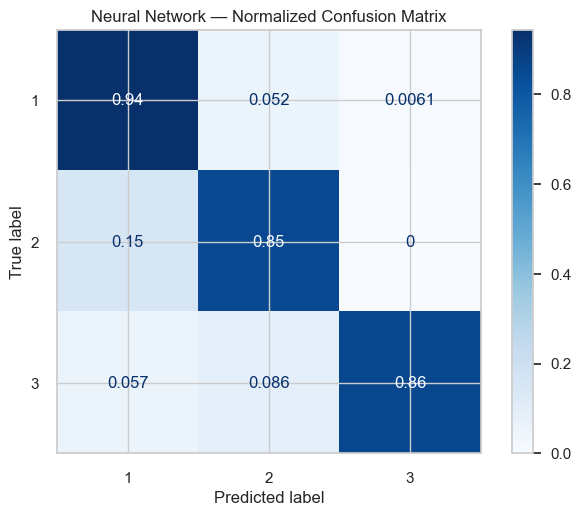

In [456]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

nn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ))
])

_ = evaluate_model(
    'Neural Network',
    nn_pipeline,
    X_train, y_train,
    X_test, y_test,
    display_report=True
)


                    Model  Balanced Accuracy  F1 Macro
0       Gradient Boosting               0.89      0.87
1          Neural Network               0.88      0.87
2           Random Forest               0.88      0.91
3  Support Vector Machine               0.88      0.81
4           Decision Tree               0.86      0.79
5   Decision Tree (Tuned)               0.85      0.80
6     Logistic Regression               0.75      0.71
7     k-Nearest Neighbors               0.74      0.78


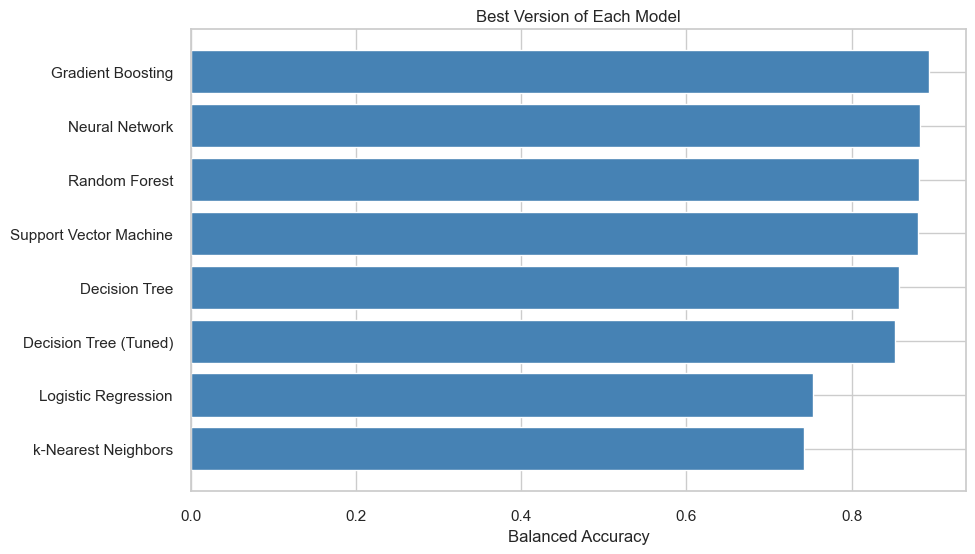

In [472]:
# Aggregate model performance
results_df = pd.DataFrame(results).sort_values('Balanced Accuracy', ascending=False)
unique_models_df = results_df.drop_duplicates(subset='Model', keep='first')
unique_models_df = unique_models_df.reset_index(drop=True)
unique_models_df
print(unique_models_df)

# Or visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(unique_models_df['Model'], unique_models_df['Balanced Accuracy'], color='steelblue')
plt.xlabel('Balanced Accuracy')
plt.title('Best Version of Each Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from torch.utils.data import Dataset

class CTGDataset(Dataset):
    def __init__(self, dataframe, feature_cols, target_col, scaler=None):
        self.X = dataframe[feature_cols].values.astype(np.float32)
        self.y = dataframe[target_col].values.astype(np.int64)
        if scaler:
            self.X = scaler.transform(self.X)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

from torch.utils.data import DataLoader, random_split

dataset = CTGDataset(df, feature_cols, 'NSP', scaler=scaler)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

import torch.nn as nn

class CTGClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
model = CTGClassifier(input_dim=len(feature_cols))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds))
torch.save(model.state_dict(), 'ctg_model_weights.pt')
